--- 1. 데이터 로딩 및 피처 생성 ---
데이터 로딩 완료: 2620 행
ECFP 핑거프린트 생성 완료.

--- 2. 분자 Scaffold 생성 중 ---
총 1044개의 고유한 Scaffold 발견.

--- 3. 5-Fold Scaffold 교차 검증 시작 ---

===== Fold 1/5 ===== 
훈련 데이터: 2062 개, 테스트 데이터: 558 개
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 2062, number of used features: 665
[LightGBM] [Info] Start training from score 7.442189
  -> Fold 1 RMSE: 0.7707, R²: 0.6120

===== Fold 2/5 ===== 
훈련 데이터: 2075 개, 테스트 데이터: 545 개
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data po


--- 5. 전체 결과 시각화 ---
성능 플롯이 '../outputs/figures/baseline_scaffold_cv_performance.png'에 저장되었습니다.


Average R2,▁
Average RMSE,▁
Std R2,▁
Std RMSE,▁
Average R2,0.35116
Average RMSE,0.89332
Std R2,0.40419
Std RMSE,0.20211


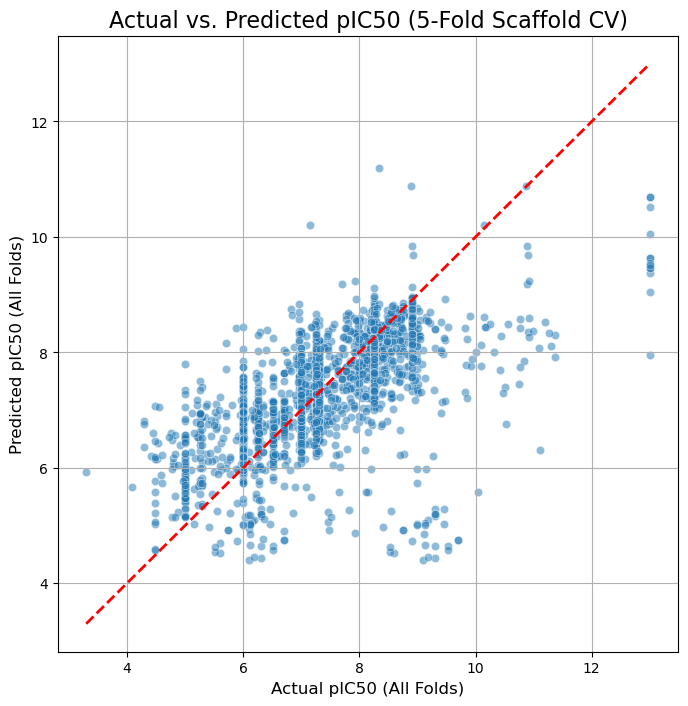

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import warnings
from rdkit import RDLogger

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

# --- 1. 데이터 및 피처 준비 ---
print("--- 1. 데이터 로딩 및 피처 생성 ---")
try:
    df = pd.read_csv('../data/processed/ask1_master_final.csv')
    print(f"데이터 로딩 완료: {len(df)} 행")
except FileNotFoundError:
    print("Error: '../data/processed/ask1_master_final.csv' 파일을 찾을 수 없습니다.")
    exit()

mols = [Chem.MolFromSmiles(s) for s in df['smiles']]
fp = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048) for m in mols]
X = np.array(fp)
y = df['pIC50'].values
print("ECFP 핑거프린트 생성 완료.")


# --- 2. Scaffold 생성 ---
print("\n--- 2. 분자 Scaffold 생성 중 ---")
scaffolds = {}
for i, mol in enumerate(mols):
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
    if scaffold not in scaffolds:
        scaffolds[scaffold] = []
    scaffolds[scaffold].append(i)

# Scaffold를 크기 순으로 정렬 (교차 검증 시 데이터 분배를 위함)
scaffold_lists = sorted(scaffolds.values(), key=len, reverse=True)
print(f"총 {len(scaffold_lists)}개의 고유한 Scaffold 발견.")


# --- 3. 5-Fold 교차 검증 ---
print("\n--- 3. 5-Fold Scaffold 교차 검증 시작 ---")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_trues = []
fold_scores = []

# Scaffold 리스트를 기준으로 폴드 분할
for fold, (train_scaffold_idx, test_scaffold_idx) in enumerate(kf.split(scaffold_lists)):
    print(f"\n===== Fold {fold+1}/5 ===== ")
    # 훈련/테스트 인덱스 생성
    train_idx = [idx for i in train_scaffold_idx for idx in scaffold_lists[i]]
    test_idx = [idx for i in test_scaffold_idx for idx in scaffold_lists[i]]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    print(f"훈련 데이터: {len(X_train)} 개, 테스트 데이터: {len(X_test)} 개")
    
    # 모델 훈련
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # 예측 및 성능 평가
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    fold_scores.append({'Fold': fold+1, 'RMSE': rmse, 'R2': r2})
    all_trues.extend(y_test)
    all_preds.extend(y_pred)
    
    print(f"  -> Fold {fold+1} RMSE: {rmse:.4f}, R²: {r2:.4f}")

# --- 4. 최종 성능 집계 및 기록 ---
print("\n--- 4. 최종 성능 집계 및 WandB 기록 ---")

# 폴드별 점수를 데이터프레임으로 변환
scores_df = pd.DataFrame(fold_scores)
avg_rmse = scores_df['RMSE'].mean()
std_rmse = scores_df['RMSE'].std()
avg_r2 = scores_df['R2'].mean()
std_r2 = scores_df['R2'].std()

print("\n교차 검증 최종 결과:")
print(scores_df)
print(f"\n평균 RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")
print(f"평균 R²: {avg_r2:.4f} ± {std_r2:.4f}")

# wandb 실험 초기화
wandb.init(project="ask1_ic50_prediction", name="baseline-lgbm-ecfp-scaffold-5fold")
# 평균 성능 지표를 wandb에 기록
wandb.log({
    "Average RMSE": avg_rmse,
    "Std RMSE": std_rmse,
    "Average R2": avg_r2,
    "Std R2": std_r2
})


# --- 5. 전체 결과 시각화 ---
print("\n--- 5. 전체 결과 시각화 ---")
plt.figure(figsize=(8, 8))
sns.scatterplot(x=all_trues, y=all_preds, alpha=0.5)
plt.plot([min(all_trues), max(all_trues)], [min(all_trues), max(all_trues)], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted pIC50 (5-Fold Scaffold CV)', fontsize=16)
plt.xlabel('Actual pIC50 (All Folds)', fontsize=12)
plt.ylabel('Predicted pIC50 (All Folds)', fontsize=12)
plt.grid(True)

plot_path = '../outputs/figures/baseline_scaffold_cv_performance.png'
plt.savefig(plot_path, dpi=300)
wandb.log({"performance_plot": wandb.Image(plot_path)})
print(f"성능 플롯이 '{plot_path}'에 저장되었습니다.")

wandb.finish()